In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Set sns style
sns.set_style('whitegrid')

# Get current file directory
dir = os.path.dirname(os.path.abspath('__file__'))

In [2]:
df_assessments = pd.read_csv(dir + '/data/assessments.csv')
df_studentInfo = pd.read_csv(dir + '/data/studentInfo.csv')
df_studentAssessment = pd.read_csv(dir + '/data/studentAssessment.csv')

# Merge assessements and studentInfo
df = pd.merge(df_assessments, df_studentInfo, on=["code_module","code_presentation"], how='left')

# Merge df and studentAssessment
df = pd.merge(df, df_studentAssessment, on=["id_student","id_assessment"], how='left')

# Remove withdrawn students
df = df[df['final_result'] != 'Withdrawn']

# Set student id as index
df = df.set_index('id_student', inplace=False)

# Change dual variables to binary
df['disability'] = df['disability'].map({'N': 0, 'Y': 1})
df["gender"] = df["gender"].map({'M': 0, 'F': 1})


# Add a passed column
    # 1 if score >= 40 and not nan
    # 0 if score < 40
    # nan if score is nan
df['passed'] = df['score'].map(lambda x: 1 if x >= 40 and not np.isnan(x) else 0 if x < 40 else np.nan)

# Remove unneeded columns
df = df.drop(['score', 'final_result'], axis=1, inplace=False)

# Remove rows with nan values
df = df.dropna(how='any', axis=0)

# Get dummies for categorical columns
df = pd.get_dummies(df, columns=['code_module', 'code_presentation', 'assessment_type','region','highest_education', 'imd_band', 'age_band'])

df.describe(include='all')

,id_assessment,date,weight,gender,num_of_prev_attempts,studied_credits,disability,date_submitted,is_banked,passed,...,imd_band_30-40%,imd_band_40-50%,imd_band_50-60%,imd_band_60-70%,imd_band_70-80%,imd_band_80-90%,imd_band_90-100%,age_band_0-35,age_band_35-55,age_band_55<=
count,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,...,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000,150787.000000
mean,26572.031753,135.262450,11.350710,0.473443,0.142731,76.054733,0.086778,118.258716,0.009371,0.964453,...,0.116270,0.102701,0.102748,0.096812,0.098669,0.096010,0.092322,0.686777,0.306810,0.006413
std,9063.111051,77.042961,14.296038,0.499296,0.444588,36.967899,0.281510,69.316318,0.096349,0.185158,...,0.320549,0.303569,0.303630,0.295703,0.298218,0.294605,0.289481,0.463806,0.461171,0.079824
min,1752.000000,12.000000,0.000000,0.000000,0.000000,30.000000,0.000000,-11.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15021.000000,61.000000,0.000000,0.000000,0.000000,60.000000,0.000000,53.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25362.000000,131.000000,8.000000,0.000000,0.000000,60.000000,0.000000,119.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,34886.000000,222.000000,18.000000,1.000000,0.000000,90.000000,0.000000,173.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,37443.000000,261.000000,100.000000,1.000000,6.000000,630.000000,1.000000,255.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


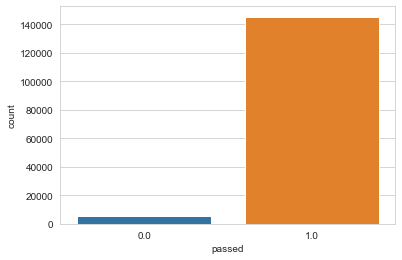

In [3]:
# Plot distribution of passed
sns.countplot(x='passed', data=df)
plt.show();

In [4]:
# Undersample the majority class
passed_not = df[df['passed'] == 0].shape[0]

# Get passed_not number of passed
passed = df[df['passed'] == 1].sample(passed_not, random_state=42)

# Concat passed and passed_not
df_undersampled = pd.concat([passed, df[df['passed'] == 0]], axis=0)

(10720, 55)


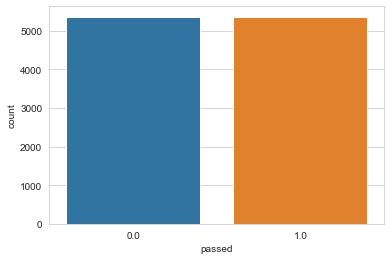

In [5]:

print(df_undersampled.shape)

# Plot distribution of passed
sns.countplot(x='passed', data=df_undersampled)
plt.show();

In [6]:
# Split data into train and test
X = df_undersampled.drop(['passed'], axis=1)
y = df_undersampled['passed']

# Scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [7]:
# Create model
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Fit model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Print results
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.77      0.73      1059
         1.0       0.75      0.67      0.71      1085

    accuracy                           0.72      2144
   macro avg       0.72      0.72      0.72      2144
weighted avg       0.73      0.72      0.72      2144

[[819 240]
 [356 729]]
Accuracy:  0.7220149253731343
Precision:  0.7523219814241486
Recall:  0.6718894009216589
F1:  0.7098344693281402


In [16]:
# Grid search
param_grid = {'n_estimators': [100, 200, 300, 400, 500, 1000], 'max_depth': [1,2,3,4,5, 10, 20, None]}
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

# Predict
y_pred = grid.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=300; total time=   0.5s
[CV] END ......................max_depth=1, n_e

In [18]:
# Print results
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

# Print results
print("classification_report:\n",classification_report(y_test, y_pred))
print("confusion_matrix:\n",confusion_matrix(y_test, y_pred))

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

{'max_depth': 20, 'n_estimators': 300}
RandomForestClassifier(max_depth=20, n_estimators=300)
0.7469680659476577
classification_report:
               precision    recall  f1-score   support

         0.0       0.74      0.78      0.76      1059
         1.0       0.77      0.73      0.75      1085

    accuracy                           0.75      2144
   macro avg       0.75      0.75      0.75      2144
weighted avg       0.75      0.75      0.75      2144

confusion_matrix:
 [[827 232]
 [296 789]]
Accuracy:  0.753731343283582
Precision:  0.7727717923604309
Recall:  0.727188940092166
F1:  0.7492877492877492


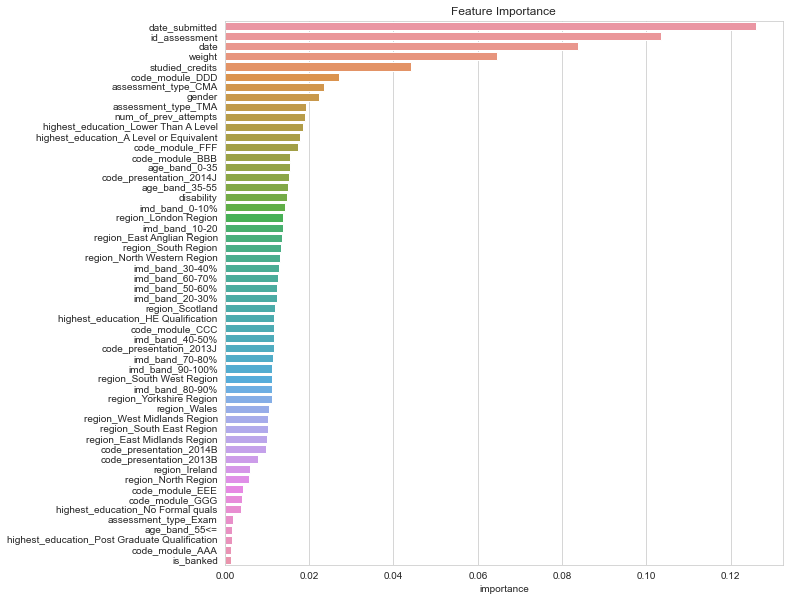

In [19]:
model = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'], max_depth=grid.best_params_['max_depth'], random_state=42)

# Fit model
model.fit(X_train, y_train)


# Get feature importance
feature_importance = pd.DataFrame(model.feature_importances_, index = df_undersampled.drop(['passed'], axis=1).columns, columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 10))
sns.barplot(x=feature_importance['importance'], y=feature_importance.index)
plt.title('Feature Importance')
plt.show()


Naive Bayes: 0.660334 (0.014356)
SVM: 0.731110 (0.014911)
KNN: 0.698926 (0.016198)
Decision Tree: 0.676425 (0.009216)
Random Forest: 0.744288 (0.014218)


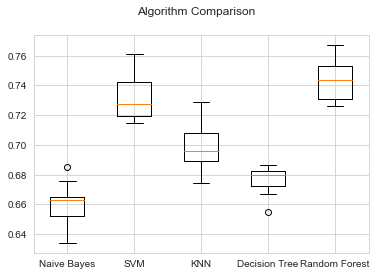

In [14]:
# Find best classifier in Naive Bayes, SVM, KNN, Decision Tree, Random Forest
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection

# Create models
models = []
models.append(('Naive Bayes', GaussianNB()))

models.append(('SVM', SVC()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('Decision Tree', DecisionTreeClassifier()))
models.append(('Random Forest', RandomForestClassifier()))

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
